In [ ]:
"""
Code for the publication Exploiting Flexibility in Multi-Energy Systems
through Distributionally Robust Chance-Constrained
Optimization by Marwan Mostafa 

Main File
"""
###############################################################################
## IMPORT PACKAGES & SCRIPTS ## 
###############################################################################
#### SCRIPTS ####
import data as dt
import griddata as gd 
import results as rs
import plot as pl
import opf as opf

net, df_pv, df, pv_generators, const_load, const_pv  = gd.setup_grid()

print(df_pv.columns)

In [ ]:
import pandas as pd

# Load the CSV file (replace 'your_file.csv' with the actual file path)
file_path = 'heatpumpPrognosis.csv'
df = pd.read_csv(file_path, sep=';')

# Display the first few rows of the dataframe
print("First few rows of the data:")
print(df.head())

# Display the header (column names) of the dataframe
print("\nColumn names (Header):")
print(df.columns)

# Print the length of the 'dayOfWeek' column
print("\nLength of the 'dayOfWeek' column:")
print(df['meanP'].count())  # .count() counts non-null entries in the column

# Print the last two values in the 'dayOfWeek' column
print("\nLast two values in the 'dayOfWeek' column:")
print(df['meanP'].tail(2))

In [ ]:
import pandas as pd

# Load the CSV file (replace 'your_file.csv' with the actual file path)
file_path = 'realData.csv'
df = pd.read_csv(file_path, sep=';')

# Display the first few rows of the dataframe
print("First few rows of the data:")
print(df.head())

# Display the header (column names) of the dataframe
print("\nColumn names (Header):")
print(df.columns)

# Print the length of the dataframe (number of rows)
print("\nNumber of rows in the data:")
print(len(df))

# Print the last two rows of the dataframe
print("\nLast two rows of the data:")
print(df.tail(2))


In [ ]:
import pandas as pd

# Load the CSV file (replace 'realData.csv' with the actual file path)
file_path = 'realData.csv'
df = pd.read_csv(file_path, sep=';', decimal=',')

# Convert the 'Unnamed: 0' column to a datetime format and set it as the index
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'], format='%Y-%m-%d %H:%M:%S')
df.set_index('Unnamed: 0', inplace=True)

# Select the first 7 days (with 15-minute intervals, there are 96 intervals per day)
first_week = df.loc[df.index < df.index[0] + pd.Timedelta(days=7)]

# Select only 'P_HOUSEHOLD' and 'P_HEATPUMP' columns for the first week
realData_winter = first_week[['P_HOUSEHOLD', 'P_HEATPUMP']]

# Display the first few rows of the dataframe
print("First few rows of the data:")
print(realData_winter.head())

# Display the header (column names) of the dataframe
print("\nColumn names (Header):")
print(realData_winter.columns)

# Print the length of the dataframe (number of rows)
print("\nNumber of rows in the data:")
print(len(realData_winter))

# Print the last two rows of the dataframe
print("\nLast two rows of the data:")
print(realData_winter.tail(2))

# Export realData_winter to a CSV file
output_file_path = 'realData_winter.csv'
realData_winter.to_csv(output_file_path, sep=';', decimal=',', index=True)

print(f"realData_winter has been successfully saved to {output_file_path}")

In [ ]:
import matplotlib.pyplot as plt
# Filter the data for rows where season is 'winter'
winter_data = df[df['season'] == 'winter']

# Convert the 'meanP' column to numeric, replacing commas with dots
winter_data['meanP'] = winter_data['meanP'].str.replace(',', '.').astype(float)

# Plot the 'meanP' column
plt.figure(figsize=(10, 6))
plt.plot(winter_data['meanP']*(32/68), marker='o', linestyle='-', color='b')
plt.title('MeanP during Winter Season')
plt.xlabel('Index')
plt.ylabel('MeanP')
plt.grid(True)
plt.show()

In [1]:
# Let's do some necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import pandapower as pp
import pandapower.topology as top
import pandapower.plotting as plot
import simbench as sb

import griddata as gd

season = 'winter'
net, const_load_household, const_load_heatpump, time_steps, df_season_heatpump_prognosis, df_household, df_heatpump, heatpump_scaling_factors_df = gd.setup_grid_irep(season)

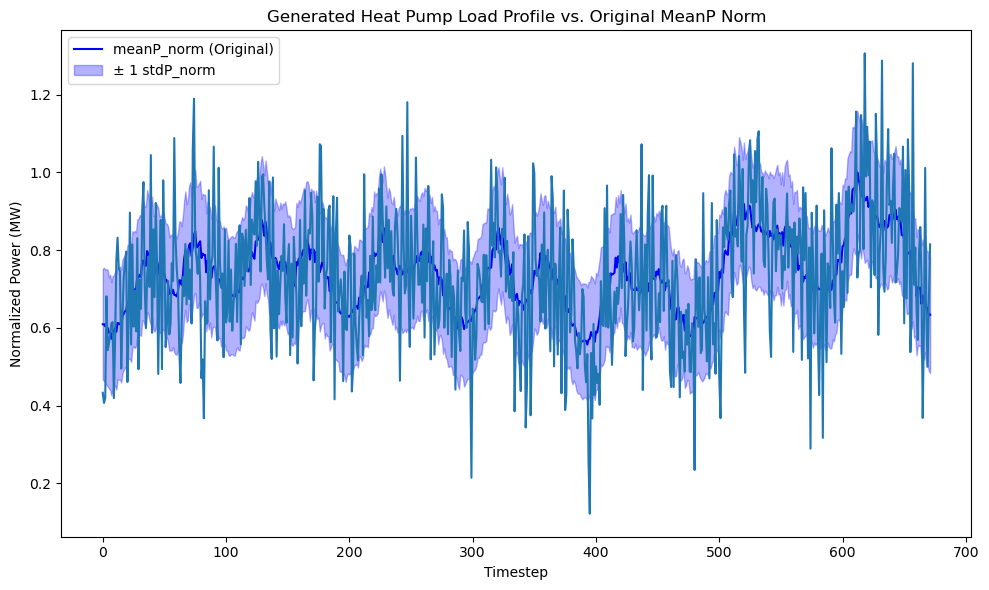

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_samples(df_season_heatpump_prognosis):

    max_mean = df_season_heatpump_prognosis['meanP'].max()
    df_season_heatpump_prognosis['meanP_norm'] = df_season_heatpump_prognosis['meanP'] / max_mean
    df_season_heatpump_prognosis['stdP_norm'] = df_season_heatpump_prognosis['stdP'] / max_mean
    
    n_samples = 10
    # Extract mean and std deviation as numpy arrays for efficient computation
    meanP = df_season_heatpump_prognosis['meanP_norm'].values
    stdP = df_season_heatpump_prognosis['stdP_norm'].values
    
   
    # Validate inputs
    if np.any(stdP < 0):
        raise ValueError("Standard deviation (stdP) cannot be negative.")
    if np.any(stdP > 10 * meanP):
        print("Warning: stdP is very large relative to meanP for some timesteps.")

    # Generate random samples (n_samples x n_timesteps)
    mc_samples = np.empty((n_samples, len(meanP)))  # Preallocate array

    for t in range(len(meanP)):
        # Generate samples for timestep `t` with specified mean and std deviation
        mc_samples[:, t] = np.random.normal(loc=meanP[t], scale=stdP[t], size=n_samples)

    return mc_samples



# Assuming df_season_heatpump_prognosis is your original data frame
mc_samples = generate_samples(df_season_heatpump_prognosis)

# Get the generated sample (first and only sample)
generated_sample = mc_samples[4]

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot the meanP_norm from the original df_season_heatpump_prognosis
plt.plot(df_season_heatpump_prognosis['Unnamed: 0'], df_season_heatpump_prognosis['meanP_norm'], label='meanP_norm (Original)', color='blue')

# Plot the generated sample's fluctuating meanP
plt.plot(generated_sample)

# Highlight the area around meanP_norm with stdP_norm (1 std deviation)
plt.fill_between(df_season_heatpump_prognosis['Unnamed: 0'], 
                 df_season_heatpump_prognosis['meanP_norm'] - df_season_heatpump_prognosis['stdP_norm'], 
                 df_season_heatpump_prognosis['meanP_norm'] + df_season_heatpump_prognosis['stdP_norm'], 
                 color='blue', alpha=0.3, label='± 1 stdP_norm')

# Labels and title
plt.xlabel('Timestep')
plt.ylabel('Normalized Power (MW)')
plt.title('Generated Heat Pump Load Profile vs. Original MeanP Norm')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()



In [3]:
plt.plot(df_season_heatpump_prognosis['p_mw'], marker='o', linestyle='-', color='b')

NameError: name 'df_season_heatpump_prognosis' is not defined

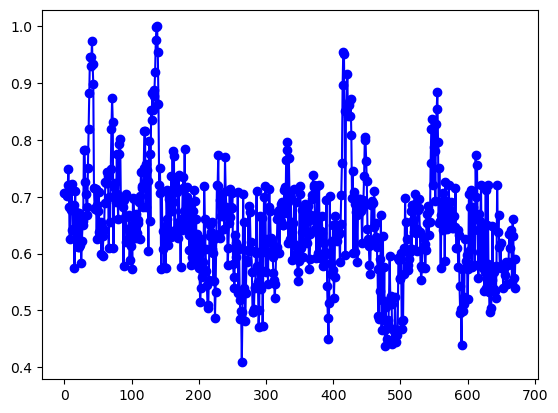

In [3]:
plt.plot(df_heatpump['P_HEATPUMP_NORM'], marker='o', linestyle='-', color='b')

In [ ]:
net.sgen.drop(net.sgen.index, inplace=True)
net.sgen

In [ ]:
lines_with_to_bus_x = net.line[net.line['to_bus'] == 14]
print(lines_with_to_bus_x)

In [ ]:
x = 16
net.line.loc[x, ['from_bus', 'to_bus']] = net.line.loc[x, ['to_bus', 'from_bus']].values


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add all buses as nodes
for bus in net.bus.index:
    G.add_node(bus)

# Add edges based on line connections
for line in net.line.itertuples():
    from_bus = line.from_bus
    to_bus = line.to_bus
    G.add_edge(from_bus, to_bus)

# Add edges for transformer connections
for trafo in net.trafo.itertuples():
    hv_bus = trafo.hv_bus
    lv_bus = trafo.lv_bus
    G.add_edge(hv_bus, lv_bus)

# Find the root bus (e.g., the slack bus or transformer bus)
root_bus = net.ext_grid.bus.iloc[0]

# Debugging: Ensure the root bus exists in the graph
if root_bus not in G.nodes:
    print(f"Warning: Root bus {root_bus} is not in the graph.")
    print(f"Available nodes: {list(G.nodes)}")
else:
    print(f"Root bus {root_bus} found.")

# Generate a topological sort to ensure hierarchy
levels = {node: 0 for node in G.nodes}
visited = set()

def assign_levels(node, level):
    if node in visited:
        return
    visited.add(node)
    levels[node] = level
    for neighbor in G.neighbors(node):
        assign_levels(neighbor, level + 1)

# Assign levels starting from the root bus
assign_levels(root_bus, 0)

# Define a position based on levels
pos = {}
nodes_by_level = {}
for node, level in levels.items():
    if level not in nodes_by_level:
        nodes_by_level[level] = []
    nodes_by_level[level].append(node)

for level, nodes in nodes_by_level.items():
    y = -level  # Downward hierarchy
    x_positions = range(len(nodes))
    for x, node in zip(x_positions, nodes):
        pos[node] = (x, y)

# Plot the graph
plt.figure(figsize=(12, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    node_color="lightblue",
    font_size=10,
    arrowsize=10,
)

# Highlight the root bus
nx.draw_networkx_nodes(G, pos, nodelist=[root_bus], node_color="red", node_size=700)
plt.title("Hierarchical Representation of the Grid with Transformer Connections")
plt.show()
